<a href="https://colab.research.google.com/github/sendyprstyo/ComputerVision/blob/main/Implementasi_R_CNN%2C_Fast_R_CNN%2C_dan_Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Periapan Environment

## Pengecekan GPU

In [1]:
import torch

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA Available: True
GPU: Tesla T4


## Install Depencies

In [3]:
# 1️⃣ Install PyTorch dan Torchvision (dengan CUDA untuk GPU)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
# 2️⃣ Install library pendukung
!pip install opencv-python matplotlib pillow numpy

In [5]:
# 3️⃣ Install pycocotools untuk evaluasi deteksi objek
!pip install pycocotools

In [6]:
# 4️⃣ Install selective search (khusus untuk R-CNN & Fast R-CNN)
!pip install selectivesearch


  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=84931b0b5dbab690358ec7c3a54593f23e098655379a23f91033a34648f9d8f6
  Stored in directory: /root/.cache/pip/wheels/7f/9b/c7/58b71f1e9fe4aa0ef8affd1c673f8818bc22a5091ea8cbbe93
Successfully built selectivesearch


In [7]:
import torch
import torchvision
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f"PyTorch Version     : {torch.__version__}")
print(f"Torchvision Version : {torchvision.__version__}")
print(f"OpenCV Version      : {cv2.__version__}")
print(f"CUDA Available      : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device          : {torch.cuda.get_device_name(0)}")

PyTorch Version     : 2.9.0+cu126
Torchvision Version : 0.24.0+cu126
OpenCV Version      : 4.12.0
CUDA Available      : True
GPU Device          : Tesla T4


## Download Dataset Sample

In [8]:
# 1️⃣ Download dataset Penn-Fudan Pedestrian
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2025-11-29 08:08:48--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  27.9MB/s    in 1.8s    

2025-11-29 08:08:50 (27.9 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [9]:
# 2️⃣ Ekstrak file ZIP
!unzip -q PennFudanPed.zip

In [10]:
# 3️⃣ Verifikasi jumlah gambar dan mask
import os

img_count = len(os.listdir("PennFudanPed/PNGImages"))
mask_count = len(os.listdir("PennFudanPed/PedMasks"))
print(f"Jumlah gambar: {img_count}")
print(f"Jumlah mask  : {mask_count}")

Jumlah gambar: 170
Jumlah mask  : 170


## Import Library Utama

In [11]:
# Library utama untuk deep learning dan data handling
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [12]:
# Library umum untuk operasi numerik dan gambar
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import time

In [13]:
# Cek device (GPU / CPU)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

if torch.cuda.is_available():
    print(f"🔥 GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU tidak aktif! Aktifkan dulu di Runtime → Change runtime type → Hardware accelerator → GPU")


✅ Using device: cuda
🔥 GPU Name: Tesla T4


In [14]:
# Verifikasi library

print("\n📦 Library Versions:")
print(f"PyTorch       : {torch.__version__}")
print(f"Torchvision   : {torchvision.__version__}")
print(f"OpenCV        : {cv2.__version__}")
print(f"NumPy         : {np.__version__}")


📦 Library Versions:
PyTorch       : 2.9.0+cu126
Torchvision   : 0.24.0+cu126
OpenCV        : 4.12.0
NumPy         : 2.0.2


# Prak 1: Implementasi R-CNN

## Langkah 1.1 – Implementasi Selective Search

In [15]:
# REGION PROPOSAL (SELECTIVE SEARCH)

import cv2, selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_region_proposals(image_path, scale=500, sigma=0.9, min_size=10):
    """Generate region proposals using Selective Search"""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lbl, regions = selectivesearch.selective_search(
        img_rgb, scale=scale, sigma=sigma, min_size=min_size
    )
    candidates = []
    for r in regions:
        if r['size'] < 2000:  # filter area kecil
            continue
        x, y, w, h = r['rect']
        if w < 20 or h < 20:
            continue
        candidates.append({'rect': (x, y, w, h), 'size': r['size']})
    candidates = sorted(candidates, key=lambda x: x['size'], reverse=True)[:2000]
    return candidates, img_rgb

In [16]:
# Uji dengan satu gambar sample
image_path = 'PennFudanPed/PNGImages/FudanPed00001.png'
proposals, img = generate_region_proposals(image_path)
print(f"Total proposals: {len(proposals)}")

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Total proposals: 342


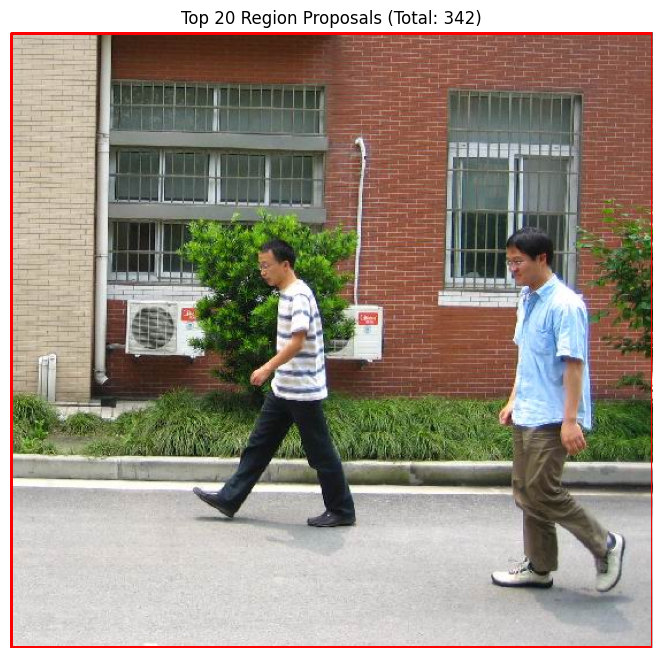

In [17]:
# Visualisasi 20 proposal teratas
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
for i, prop in enumerate(proposals[:20]):
    x, y, w, h = prop['rect']
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_title(f"Top 20 Region Proposals (Total: {len(proposals)})")
plt.axis('off')
plt.show()

## Langkah 1.2 – Feature Extraction dengan CNN Pre-Trained

In [18]:
import torch, torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np

class RCNNFeatureExtractor:
    """Feature extractor menggunakan pre-trained ResNet50"""
    def __init__(self, device='cuda'):
        self.device = device
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.model = resnet50(weights=weights)
        self.model = nn.Sequential(*list(self.model.children())[:-1])  # hapus FC layer
        self.model.to(device).eval()
        self.transform = weights.transforms()

    def extract_features(self, image, regions):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        feats, valid = [], []
        with torch.no_grad():
            for r in regions:
                x, y, w, h = r['rect']
                try:
                    region_img = image.crop((x, y, x+w, y+h))
                    region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)
                    f = self.model(region_tensor).squeeze()
                    feats.append(f.cpu())
                    valid.append(r)
                except:
                    continue
        if not feats: return None, []
        return torch.stack(feats), valid

# Uji ekstraksi fitur
extractor = RCNNFeatureExtractor(device=device)
features, valid_regions = extractor.extract_features(img, proposals[:100])
print(f"Ekstraksi fitur: {features.shape} | Region valid: {len(valid_regions)}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


Ekstraksi fitur: torch.Size([100, 2048]) | Region valid: 100


## Langkah 1.3: Classification dengan SVM

In [19]:
# ============================
# LANGKAH 1.3: CLASSIFICATION DENGAN SVM
# ============================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

class RCNNClassifier:
    """
    SVM classifier untuk R-CNN
    """
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
        self.scaler = StandardScaler()
        self.svm = SVC(kernel='linear', probability=True, random_state=42)

    def train(self, features, labels):
        """
        Melatih SVM dengan data fitur hasil ekstraksi CNN.
        Args:
            features : array [N, feature_dim]
            labels   : array [N]
        """
        features_scaled = self.scaler.fit_transform(features)
        self.svm.fit(features_scaled, labels)
        print(f"SVM trained with {len(features)} samples and {self.num_classes} classes.")

    def predict(self, features):
        """
        Memprediksi kelas objek berdasarkan fitur baru.
        Returns:
            predictions  : label prediksi
            probabilities: probabilitas tiap kelas
        """
        features_scaled = self.scaler.transform(features)
        predictions = self.svm.predict(features_scaled)
        probabilities = self.svm.predict_proba(features_scaled)
        return predictions, probabilities


## Langkah 1.4 – R-CNN Simplified Inference

In [20]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms

def rcnn_inference_simplified(image_path, threshold=0.5):
    print("Step 1: Generate region proposals...")
    proposals, img = generate_region_proposals(image_path)
    print(f"Generated {len(proposals)} proposals")

    print("Step 2: Load pre-trained Faster R-CNN for classification...")
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT').to(device).eval()

    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(Image.fromarray(img)).to(device)

    with torch.no_grad():
        preds = model([img_tensor])

    boxes = preds[0]['boxes'].cpu().numpy()
    labels = preds[0]['labels'].cpu().numpy()
    scores = preds[0]['scores'].cpu().numpy()

    keep = scores > threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
    print(f"Detected {len(boxes)} objects (threshold={threshold})")

    return boxes, labels, scores, img

In [21]:
# Jalankan inference
boxes, labels, scores, img = rcnn_inference_simplified(image_path, threshold=0.7)

Step 1: Generate region proposals...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Generated 342 proposals
Step 2: Load pre-trained Faster R-CNN for classification...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 190MB/s]


Detected 2 objects (threshold=0.7)


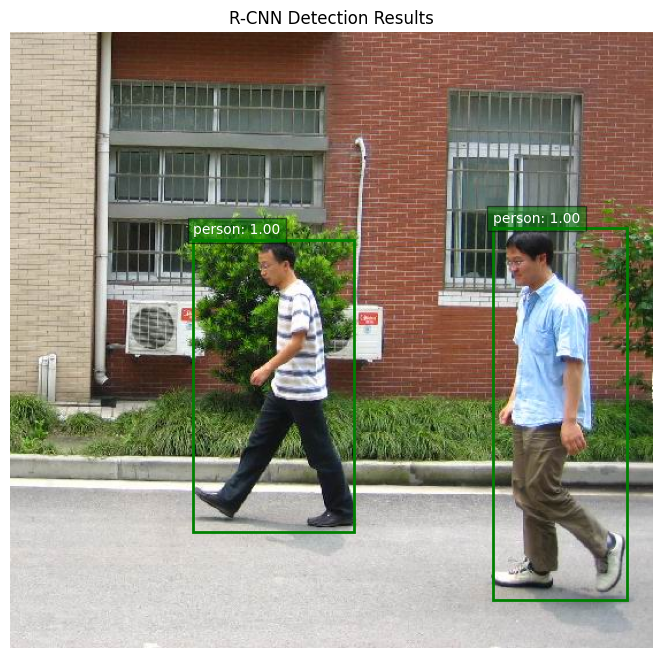

In [22]:
# Visualisasi hasil
COCO_CLASSES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle']
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f'class_{label}'
    ax.text(x1, y1-5, f'{name}: {score:.2f}', bbox=dict(facecolor='green', alpha=0.5),
            fontsize=10, color='white')
ax.set_title('R-CNN Detection Results')
plt.axis('off')
plt.show()

# Praktikum 2: Implementasi Fast R-CNN

## Langkah 2.1 – Implementasi RoI Pooling

In [23]:
# ROI POOLING

import torch
import torchvision.ops as ops

class FastRCNNRoIPooling:
    """
    Implementasi RoI Pooling untuk Fast R-CNN
    """
    def __init__(self, output_size=(7, 7), spatial_scale=1.0):
        self.output_size = output_size
        self.spatial_scale = spatial_scale

    def forward(self, features, boxes):
        """
        Menerapkan RoI Pooling
        Args:
            features : feature map tensor [1, C, H, W]
            boxes    : daftar koordinat [N, 4] (x1, y1, x2, y2)
        Returns:
            pooled_features : tensor hasil pooling [N, C, output_h, output_w]
        """
        boxes_tensor = torch.FloatTensor(boxes).to(features.device)
        batch_idx = torch.zeros((boxes_tensor.shape[0], 1), dtype=boxes_tensor.dtype, device=features.device)
        rois = torch.cat([batch_idx, boxes_tensor], dim=1)
        pooled = ops.roi_pool(features, rois, output_size=self.output_size, spatial_scale=self.spatial_scale)
        return pooled


In [24]:
# ⚙️ Uji coba RoI Pooling
def test_roi_pooling():
    feature_map = torch.randn(1, 512, 50, 50).to(device)  # contoh feature map
    boxes = [[10, 10, 100, 100], [150, 150, 300, 300], [200, 50, 400, 200]]
    roi_pool = FastRCNNRoIPooling(output_size=(7, 7), spatial_scale=1/16)
    pooled_features = roi_pool.forward(feature_map, boxes)
    print(f"Feature map: {feature_map.shape}")
    print(f"Jumlah boxes: {len(boxes)}")
    print(f"Hasil pooling: {pooled_features.shape}")

test_roi_pooling()

Feature map: torch.Size([1, 512, 50, 50])
Jumlah boxes: 3
Hasil pooling: torch.Size([3, 512, 7, 7])


## Langkah 2.2 – Implementasi Model Fast R-CNN

In [25]:
# FAST R-CNN MODEL

import torch.nn as nn
import torchvision

class FastRCNN(nn.Module):
    """Implementasi Fast R-CNN menggunakan backbone ResNet50"""
    def __init__(self, num_classes=91, roi_output_size=(7, 7)):
        super(FastRCNN, self).__init__()
        self.num_classes = num_classes
        self.roi_output_size = roi_output_size

        # Backbone: ResNet tanpa FC layer terakhir
        resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.spatial_scale = 1.0 / 32.0  # stride backbone

        # Dimensi fitur setelah RoI pooling
        feature_dim = 2048 * roi_output_size[0] * roi_output_size[1]

        # Fully connected layers
        self.fc1 = nn.Linear(feature_dim, 4096)
        self.fc2 = nn.Linear(4096, 4096)

        # Output head
        self.cls_score = nn.Linear(4096, num_classes)
        self.bbox_pred = nn.Linear(4096, num_classes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, boxes):
        """Forward pass Fast R-CNN"""
        features = self.backbone(images)
        pooled = ops.roi_pool(features, boxes,
                              output_size=self.roi_output_size,
                              spatial_scale=self.spatial_scale)

        pooled = pooled.view(pooled.size(0), -1)
        x = self.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        cls_scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return cls_scores, bbox_deltas

In [26]:
# ✅ Inisialisasi model
fast_rcnn_model = FastRCNN(num_classes=91).to(device)
print("Fast R-CNN model initialized.")
print(f"Total parameters: {sum(p.numel() for p in fast_rcnn_model.parameters()):,}")

Fast R-CNN model initialized.
Total parameters: 453,199,367


## Langkah 2.3 – Inference Fast R-CNN (Demo)

In [27]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [28]:
# Gunakan model pre-trained Faster R-CNN untuk demo
model_pretrained = fasterrcnn_resnet50_fpn(weights='DEFAULT').to(device).eval()

def fast_rcnn_demo(image_path, threshold=0.7):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img).to(device)
    with torch.no_grad():
        preds = model_pretrained([img_tensor])
    boxes = preds[0]['boxes'].cpu().numpy()
    labels = preds[0]['labels'].cpu().numpy()
    scores = preds[0]['scores'].cpu().numpy()

    keep = scores > threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
    return boxes, labels, scores, np.array(img)

In [29]:
# Jalankan inference
image_path = "PennFudanPed/PNGImages/FudanPed00005.png"
boxes, labels, scores, img = fast_rcnn_demo(image_path, threshold=0.7)

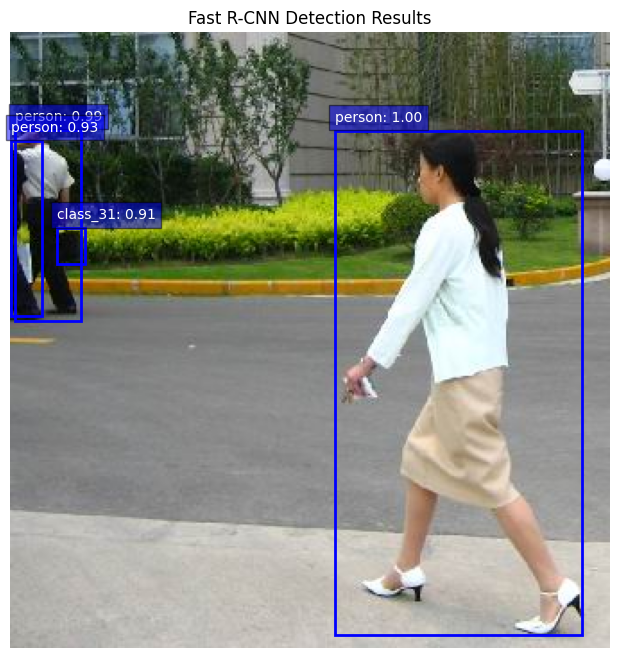

In [30]:
# Visualisasi hasil
COCO_CLASSES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle']
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                             edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f'class_{label}'
    ax.text(x1, y1-5, f'{name}: {score:.2f}', bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=10, color='white')
ax.set_title('Fast R-CNN Detection Results')
plt.axis('off')
plt.show()

## Langkah 2.4 – Perbandingan R-CNN vs Fast R-CNN

In [31]:
import time

def compare_rcnn_vs_fast_rcnn(image_path):
    print("=" * 60)
    print("Comparing R-CNN vs Fast R-CNN")
    print("=" * 60)

    # R-CNN (simplified)
    start = time.time()
    _, _, _, _ = rcnn_inference_simplified(image_path, threshold=0.7)
    rcnn_time = time.time() - start
    print(f"R-CNN time: {rcnn_time:.2f} s")

    # Fast R-CNN (pre-trained demo)
    start = time.time()
    _, _, _, _ = fast_rcnn_demo(image_path, threshold=0.7)
    fast_time = time.time() - start
    print(f"Fast R-CNN time: {fast_time:.2f} s")

    print("\nSPEEDUP:", f"{rcnn_time / fast_time:.2f}x faster")

compare_rcnn_vs_fast_rcnn("PennFudanPed/PNGImages/FudanPed00010.png")


Comparing R-CNN vs Fast R-CNN
Step 1: Generate region proposals...
Generated 329 proposals
Step 2: Load pre-trained Faster R-CNN for classification...
Detected 5 objects (threshold=0.7)
R-CNN time: 2.70 s
Fast R-CNN time: 0.12 s

SPEEDUP: 23.25x faster


# Praktikum 3: Implementasi Faster R-CNN

## Langkah 3.1 – Load Pre-trained Faster R-CNN

In [32]:
# LOAD PRETRAINED MODEL

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# Load pre-trained model
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model_faster_rcnn = fasterrcnn_resnet50_fpn(weights=weights)
model_faster_rcnn.to(device)
model_faster_rcnn.eval()

print("✅ Faster R-CNN Model Loaded")
print("   Trained on: COCO dataset (80 classes)")
print("   Backbone  : ResNet-50 + FPN (Feature Pyramid Network)")

✅ Faster R-CNN Model Loaded
   Trained on: COCO dataset (80 classes)
   Backbone  : ResNet-50 + FPN (Feature Pyramid Network)


## Langkah 3.2 – Inference Function

In [33]:
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

def faster_rcnn_inference(image_path, model, threshold=0.5):
    """Pipeline inferensi Faster R-CNN"""
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img).to(device)

    model.eval()
    with torch.no_grad():
        start = time.time()
        preds = model([img_tensor])
        inf_time = time.time() - start

    boxes = preds[0]['boxes'].cpu().numpy()
    labels = preds[0]['labels'].cpu().numpy()
    scores = preds[0]['scores'].cpu().numpy()

    keep = scores > threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

    print(f"Inference time: {inf_time:.3f}s, Detected {len(boxes)} objects above {threshold}")
    return boxes, labels, scores, np.array(img), inf_time

# Jalankan inferensi pada salah satu gambar
image_path = "PennFudanPed/PNGImages/FudanPed00015.png"
boxes, labels, scores, img, t = faster_rcnn_inference(image_path, model_faster_rcnn, threshold=0.7)


Inference time: 0.133s, Detected 11 objects above 0.7


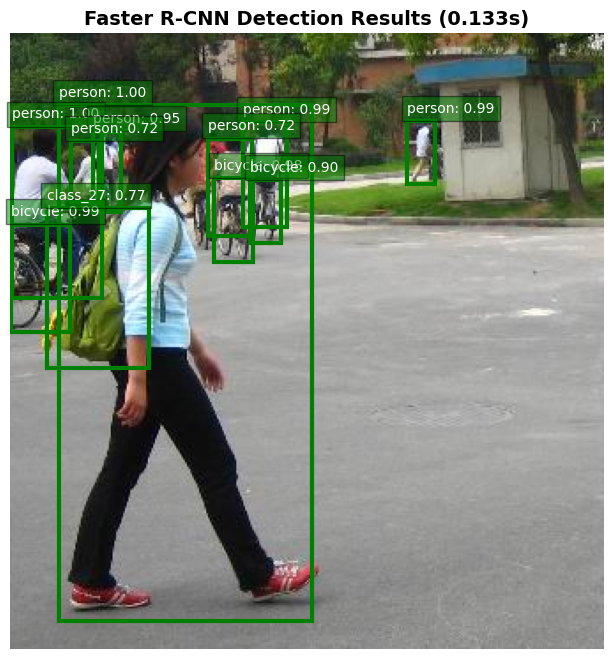

In [34]:
COCO_CLASSES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle',
                'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3,
                             edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    cls_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f"class_{label}"
    ax.text(x1, y1 - 5, f"{cls_name}: {score:.2f}",
            bbox=dict(facecolor='green', alpha=0.5),
            fontsize=10, color='white')
ax.set_title(f"Faster R-CNN Detection Results ({t:.3f}s)", fontsize=14, weight='bold')
plt.axis('off')
plt.show()


## Langkah 3.3 – Batch Inference untuk Beberapa Gambar

In [35]:
def faster_rcnn_batch_inference(image_paths, model, threshold=0.5):
    results = []
    total_time = 0
    model.eval()

    for path in image_paths:
        print(f"Processing: {path}")
        boxes, labels, scores, img, t = faster_rcnn_inference(path, model, threshold)
        total_time += t
        results.append({'path': path, 'boxes': boxes, 'labels': labels, 'scores': scores, 'image': img})

    print(f"\nAverage inference time: {total_time/len(image_paths):.3f}s per image")
    return results

sample_images = [
    "PennFudanPed/PNGImages/FudanPed00001.png",
    "PennFudanPed/PNGImages/FudanPed00005.png",
    "PennFudanPed/PNGImages/FudanPed00010.png",
    "PennFudanPed/PNGImages/FudanPed00015.png",
]

results = faster_rcnn_batch_inference(sample_images, model_faster_rcnn, threshold=0.7)


Processing: PennFudanPed/PNGImages/FudanPed00001.png
Inference time: 0.139s, Detected 2 objects above 0.7
Processing: PennFudanPed/PNGImages/FudanPed00005.png
Inference time: 0.112s, Detected 4 objects above 0.7
Processing: PennFudanPed/PNGImages/FudanPed00010.png
Inference time: 0.083s, Detected 5 objects above 0.7
Processing: PennFudanPed/PNGImages/FudanPed00015.png
Inference time: 0.083s, Detected 11 objects above 0.7

Average inference time: 0.104s per image


## Langkah 3.4 – Fine-tuning di Dataset Custom

In [37]:
!pip install --upgrade torch torchvision torchaudio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 728.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

In [1]:
import torchvision
print(torchvision.__version__)


0.24.1+cu128


In [3]:
# ============================
# LANGKAH 3.4 : Fine-tuning Faster R-CNN pada Custom Dataset
# ============================

import os
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
from torchvision.ops import masks_to_boxes
from torchvision import tv_tensors
from torchvision import transforms as T

# -----------------------------
# Custom Dataset Class
# -----------------------------
class PennFudanDataset(data.Dataset):
    """
    Custom dataset for Penn-Fudan Pedestrian Detection
    """
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Load all image and mask files
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert mask to numpy array
        mask = np.array(mask)

        # Each pedestrian instance has unique color ID
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]      # remove background (0)

        # Binary masks
        masks = mask == obj_ids[:, None, None]

        # Convert masks to bounding boxes
        boxes = masks_to_boxes(torch.as_tensor(masks, dtype=torch.uint8))

        # Labels (only one class: person)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)

        # Wrap everything into tv_tensors (new style torchvision >=0.15)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.size[::-1]),
            "labels": labels,
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        # Convert image ke Tensor
        img = T.ToTensor()(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


# -----------------------------
# Test dataset
# -----------------------------
dataset = PennFudanDataset("PennFudanPed")
print(f"📁 Dataset size: {len(dataset)}")

# Ambil satu contoh untuk verifikasi
img, target = dataset[0]
print("✅ Contoh data berhasil dimuat!")
print("Tipe image:", type(img))
print("Target keys:", target.keys())
print("Jumlah objek:", len(target["boxes"]))
print("Boxes shape:", target["boxes"].shape)
print("Labels:", target["labels"])


📁 Dataset size: 170
✅ Contoh data berhasil dimuat!
Tipe image: <class 'torch.Tensor'>
Target keys: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
Jumlah objek: 2
Boxes shape: torch.Size([2, 4])
Labels: tensor([1, 1])


In [6]:
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB 726.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 824.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Ganti Python ke versi 3.10 yang stabil untuk PyTorch
!sudo apt-get update -y
!sudo apt-get install python3.10 python3.10-dev python3.10-distutils -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python3 -m pip install --upgrade pip


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.4 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,491 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backp

In [3]:
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121 -q

In [2]:
!sudo apt-get update -y
!sudo apt-get install -y python3.10 python3.10-dev python3.10-distutils
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python3 -m pip install --upgrade pip
!pip install "numpy<2.0" torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121 -q


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [3]:
import sys, torch, torchvision, numpy
print("🐍 Python:", sys.version)
print("🔢 NumPy:", numpy.__version__)
print("🔥 Torch:", torch.__version__)
print("🖼️ TorchVision:", torchvision.__version__)

from torchvision.models.detection import FastRCNNPredictor
print("✅ FastRCNNPredictor berhasil di-import tanpa error!")


🐍 Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
🔢 NumPy: 2.0.2
🔥 Torch: 2.2.2+cu121
🖼️ TorchVision: 0.17.2+cu121


ImportError: cannot import name 'FastRCNNPredictor' from 'torchvision.models.detection' (/usr/local/lib/python3.12/dist-packages/torchvision/models/detection/__init__.py)

In [6]:
!echo "🔧 Installing Python 3.10..."

🔧 Installing Python 3.10...


In [7]:
!sudo apt-get update -y

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [8]:
!sudo apt-get install -y python3.10 python3.10-dev python3.10-distutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.10-distutils'
python3-distutils is already the newest version (3.10.8-1~22.04).
python3.10 is already the newest version (3.10.12-1~22.04.12).
python3.10-dev is already the newest version (3.10.12-1~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [9]:
!echo "🔁 Switching default python3 -> 3.10..."

🔁 Switching default python3 -> 3.10...


In [10]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python3 -V

Python 3.12.12


In [11]:
!echo "📦 Installing pip & compatible libraries..."

📦 Installing pip & compatible libraries...


In [12]:
!python3 -V


Python 3.12.12


In [1]:
# ============================
# LANGKAH 3.5 : Training Loop untuk Fine-tuning
# ============================

import torch
import torch.utils.data as data
from torch.utils.data import random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FastRCNNPredictor
import matplotlib.pyplot as plt

# ----------------------------------------
# 1️⃣ Fungsi untuk mendapatkan model
# ----------------------------------------
def get_model_for_finetuning(num_classes):
    """
    Mendapatkan model Faster R-CNN untuk fine-tuning.
    Args:
        num_classes: Jumlah kelas (termasuk background)
    Returns:
        model: Model Faster R-CNN siap dilatih
    """
    # Load model pre-trained COCO
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Ganti head classifier-nya agar sesuai jumlah kelas kita
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# ----------------------------------------
# 2️⃣ Fungsi training untuk satu epoch
# ----------------------------------------
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """
    Melatih model selama satu epoch
    """
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(data_loader):
        # Kirim ke GPU
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch}], Step [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"✅ Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss


# ----------------------------------------
# 3️⃣ Collate function untuk DataLoader
# ----------------------------------------
def collate_fn(batch):
    return tuple(zip(*batch))


# ----------------------------------------
# 4️⃣ Split dataset menjadi train dan val
# ----------------------------------------
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"📊 Train size: {len(train_dataset)}")
print(f"📊 Validation size: {len(val_dataset)}")

train_loader = data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)


# ----------------------------------------
# 5️⃣ Siapkan model, optimizer, dan scheduler
# ----------------------------------------
num_classes = 2  # background + person
model_finetuned = get_model_for_finetuning(num_classes)
model_finetuned.to(device)

params = [p for p in model_finetuned.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# ----------------------------------------
# 6️⃣ Jalankan training
# ----------------------------------------
num_epochs = 2  # untuk demo, bisa ubah jadi 5–10
training_losses = []

print(f"\n🚀 Starting training for {num_epochs} epochs...")
print("=" * 60)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 60)

    avg_loss = train_one_epoch(model_finetuned, optimizer, train_loader, device, epoch)
    training_losses.append(avg_loss)

    # Update learning rate
    lr_scheduler.step()
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

print(f"\n{'='*60}")
print("🎯 Training completed!")
print(f"{'='*60}\n")


# ----------------------------------------
# 7️⃣ Plot grafik loss
# ----------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses,
         marker='o', linewidth=2, color='orange', markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()


# ----------------------------------------
# 8️⃣ Simpan model hasil training
# ----------------------------------------
torch.save(model_finetuned.state_dict(), 'faster_rcnn_finetuned.pth')
print("\n💾 Model saved as 'faster_rcnn_finetuned.pth'")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: cannot import name 'FastRCNNPredictor' from 'torchvision.models.detection' (/usr/local/lib/python3.12/dist-packages/torchvision/models/detection/__init__.py)